In [1]:
#!/usr/bin/env python3

import glob as glob
import os
import shutil
import datetime as datetime
from multiprocessing import Pool
import json

import pandas as pd
import altair as alt
from tqdm import tqdm, tnrange, tqdm_notebook

In [2]:
names = pd.read_csv("./files/names.csv", index_col="MeridiosName")
metrics = pd.read_csv(
    "./files/metrics.csv", index_col="MeridiosMetric", dtype={"MeridiosMetric": object}
)

In [3]:
df = pd.DataFrame()

files = glob.iglob("./data/*.csv")
for file in tqdm_notebook(files, total=len(glob.glob("./data/*csv")), desc="CSV Files"):
    file_df = pd.read_csv(file, usecols=["NAME", "Metricname", "SeenNum", "SeenDenom"])
    file_df["Name"] = file_df.NAME.map(names.Name)
    file_df["Type"] = file_df.NAME.map(names.Type)
    file_df["Clinic"] = file_df.NAME.map(names.Clinic)
    file_df["Metric"] = file_df.Metricname.map(metrics.Metric)

    # Meridios report doesn't have FCN summary so create it from clinic data.
    clinics_df = file_df[(file_df["Type"] == "Clinic")]
    fcn_data = []
    for metric in clinics_df.Metric.unique():
        metric_df = clinics_df[(clinics_df["Metric"] == metric)]
        fcn_numerator = metric_df.SeenNum.sum()
        fcn_denominator = metric_df.SeenDenom.sum()
        dataline = ("", "", fcn_numerator, fcn_denominator, "FCN", "FCN", "FCN", metric)
        fcn_data.append(dataline)
    fcn_df = pd.DataFrame.from_records(fcn_data, columns=metric_df.columns)
    file_df = file_df.append(fcn_df, ignore_index=True)

    # Reduce precision to basis points so we don't have to format it everywhere.
    file_df["Percentage"] = round(file_df["SeenNum"] / file_df["SeenDenom"], 4)

    # Meridios reports have unreliable datetimes. So create from filename.
    # Zero Padded for easy analysis.
    filename_parts = file[7:-4].split(" ")
    if len(str(filename_parts[0])) is 10:
        file_df["Date"] = datetime.datetime.strptime(filename_parts[0], "%m.%d.%Y")

        # Smaller dataframes use less memory and reduce eventual JSON export size.
        file_df.drop(["SeenNum", "SeenDenom"], axis=1, inplace=True)
        df = df.append(file_df)
    else:
        raise ValueError("CSV Filename should have Zero Padded Date")

# df.dtypes
# df.info()
# df.describe()
# df.columns
# df.Metric.unique()
# df.head()
# metrics.head()

In [4]:
if len(set(df.NAME.unique()) - set(names.index.unique())) > 1:
    print(
        "Missing Provider in names.csv:\n",
        set(df.NAME.unique()) - set(names.index.unique()),
    )
df.drop(["NAME"], axis=1, inplace=True)


df.drop(["Metricname"], axis=1, inplace=True)

big_error_df = df[(df["Percentage"] > 1)]
if not big_error_df.empty:
    print("Percentages can't be over 100:\n", big_error_df)

under_zero_df = df[(df["Percentage"] < 0)]
if not under_zero_df.empty:
    print("Percentages can't be less than 0:\n", under_zero_df)

Missing Metric in metrics.csv:
 {'', 'HgbA1c < 7.0                     ', 'Advance Directive - Patients >55yrs w/Advance Directive ', 'HbA1c test last 365 days     ', 'HgbA1c NOT > 9.0 (poor control) ', 'Blood Pressure NOT Controlled  >140/90 mm Hg    ', 'Copy of Advance Directive - Patients >55yrs w/Advance Directive '}


In [5]:
def make_individual_metric_json(metric, name):
    """
    Makes a chart json for a single metric and a single provider.

    Assumes: dataframe 'df' that has all the data from CSVs
    Assumes: dataframes 'names' and 'metrics' for lookups
    """

    provider_df = df[
        (df["Metric"] == metric) & (df["Type"] == "Individual") & (df["Name"] == name)
    ]

    provider_df = provider_df.drop(["Name", "Type", "Clinic", "Metric"], axis=1)

    # Lookup clinic from the provider name in the names dataframe.
    # Make a comparison dataframe.
    clinic_name = names[names.Name == name].iloc[0].Clinic
    clinic_df = df[(df["Metric"] == metric) & (df["Name"] == clinic_name)]
    clinic_df = clinic_df.drop(["Name", "Type", "Clinic", "Metric"], axis=1)

    fcn_df = df[(df["Metric"] == metric) & (df["Type"] == "FCN")]
    fcn_df = fcn_df.drop(["Name", "Type", "Clinic", "Metric"], axis=1)

    # Lookup the metric target -- not all metrics have a target.
    metric_target = metrics[metrics.Metric == metric].iloc[0].Target

    # If there's a target value, we'll make a rule on graph.
    if metric_target:
        metricdf = pd.DataFrame([{"TargetValue": metric_target, "Title": "Target"}])

    # Make a Current dataframe to use for Strip Chart.
    current_metric = df[
        (df["Metric"] == metric)
        & (df["Type"] == "Individual")
        & (df["Date"] == current_date)
    ]
    highlight_provider = current_metric
    highlight_provider = highlight_provider[(highlight_provider["Name"] == name)]
    current_metric = current_metric.drop(
        ["Name", "Type", "Clinic", "Metric", "Date"], axis=1
    )
    highlight_provider = highlight_provider.drop(
        ["Name", "Type", "Clinic", "Metric", "Date"], axis=1
    )

    provider_progress_line = (
        alt.Chart(provider_df)
        .mark_line(strokeWidth=4)
        .encode(
            alt.X("Date:T", title=""),
            alt.Y(
                "Percentage:Q",
                axis=alt.Axis(format="%", title=""),
                scale=alt.Scale(domain=(0, 1)),
            ),
            # color=alt.Color("Name:N", legend=None, ),
            color=alt.ColorValue("#9467bd"),
        )
        .properties(width=200, height=200)
    )

    clinic_progress_line = (
        alt.Chart(clinic_df)
        .mark_line(strokeWidth=2)
        .encode(
            alt.X("Date:T", title=""),
            alt.Y("Percentage:Q"),
            color=alt.ColorValue("#ffbb78"),
        )
    )

    fcn_progress_line = (
        alt.Chart(fcn_df)
        .mark_line(strokeWidth=2)
        .encode(
            alt.X("Date:T", title=""),
            alt.Y("Percentage:Q"),
            color=alt.ColorValue("#aec7e8"),
        )
    )

    if metric_target:
        metric_target_rule = (
            alt.Chart(metricdf)
            .mark_rule(strokeWidth=1, strokeDash=[4, 2])
            .encode(y="TargetValue:Q", color=alt.ColorValue("#2ca02c"))
        )

    fcn_current_strip_chart = (
        alt.Chart(current_metric)
        .mark_tick(color="#ddd")
        .encode(
            alt.Y(
                "Percentage:Q",
                axis=alt.Axis(format="%", title="", labels=False),
                scale=alt.Scale(domain=(0, 1)),
            )
        )
        .properties(height=200)
    )

    provider_highlight_strip = (
        alt.Chart(highlight_provider)
        .mark_tick()
        .encode(
            alt.Y("Percentage:Q"),
            opacity=alt.value("1.0"),
            color=alt.ColorValue("#9467bd"),
        )
    )

    provider_percent = provider_highlight_strip.mark_text(
        align="left", baseline="middle", dx=15, size=20
    ).encode(text=alt.Text("Percentage:Q", format=".2%"))

    if metric_target:
        chart = (
            metric_target_rule
            + fcn_progress_line
            + clinic_progress_line
            + provider_progress_line
            | (fcn_current_strip_chart + provider_highlight_strip + provider_percent)
        )
    else:
        chart = fcn_progress_line + clinic_progress_line + provider_progress_line | (
            fcn_current_strip_chart + provider_highlight_strip + provider_percent
        )
    return chart.to_json()

In [6]:
def save_individual_chart_data(name):
    json_data = ""
    for metric in main_metrics:
        chart_data = make_individual_metric_json(metric, name)
        chart_data_json = json.loads(chart_data)
        json_minified = json.dumps(chart_data_json, separators=(",", ":"))
        json_data += "var " + metric.replace(" ", "_") + " = " + json_minified + ";\n"
    foldername = savefolder(name)
    with open(foldername + "chart_data.json", "w") as savefile:
        savefile.write(json_data)

In [7]:
def make_clinic_metric_json(metric, clinic_name):
    """
    Makes a chart for a single metric and a clinic.

    Assumes: dataframe 'df' that has all the data from CSVs
    Assumes: dataframes 'names' and 'metrics' for lookups
    """

    clinic_df = df[(df["Metric"] == metric) & (df["Name"] == clinic_name)]
    clinic_df = clinic_df.drop(["Name", "Type", "Clinic", "Metric"], axis=1)

    fcn_df = df[(df["Metric"] == metric) & (df["Type"] == "FCN")]
    fcn_df = fcn_df.drop(["Name", "Type", "Clinic", "Metric"], axis=1)

    metric_target = metrics[metrics.Metric == metric].iloc[0].Target
    if metric_target:
        metricdf = pd.DataFrame([{"TargetValue": metric_target, "Title": "Target"}])

    current_metric = df[
        (df["Metric"] == metric)
        & (df["Type"] == "Clinic")
        & (df["Date"] == current_date)
    ]

    clinic_current_metric = df[
        (df["Metric"] == metric)
        & (df["Name"] == clinic_name)
        & (df["Date"] == current_date)
    ]

    clinic_progress_line = (
        alt.Chart(clinic_df)
        .mark_line(strokeWidth=4)
        .encode(
            alt.X("Date:T", title=""),
            alt.Y(
                "Percentage:Q",
                axis=alt.Axis(format="%", title=""),
                scale=alt.Scale(domain=(0, 1)),
            ),
            color=alt.ColorValue("#ff7f0e"),
        )
        .properties(width=200, height=200)
    )

    clinic_progress_line += (
        alt.Chart(clinic_current_metric)
        .mark_text(align="left", baseline="top", dx=25, dy=-95, size=20)
        .encode(
            text=alt.Text("Percentage:Q", format=".2%"), color=alt.ColorValue("#ff7f0e")
        )
    )

    fcn_progress_line = (
        alt.Chart(fcn_df)
        .mark_line(strokeWidth=2)
        .encode(
            alt.X("Date:T", title=""),
            alt.Y(
                "Percentage:Q",
                axis=alt.Axis(format="%", title=""),
                scale=alt.Scale(domain=(0, 1)),
            ),
            color=alt.ColorValue("#aec7e8"),
        )
    )

    if metric_target:
        metric_target_rule = (
            alt.Chart(metricdf)
            .mark_rule(strokeWidth=1, strokeDash=[4, 2])
            .encode(y="TargetValue:Q", color=alt.ColorValue("#2ca02c"))
        )

    clinic_providers = sorted(
        single_providers[single_providers.Clinic == clinic_name].Name.unique(),
        key=lambda x: x.split(" ")[1],
    )

    current_metric = df[
        (df["Metric"] == metric)
        & (df["Date"] == current_date)
        & (df["Name"].isin(clinic_providers))
    ]
    current_metric = current_metric.drop(["Type", "Clinic", "Metric", "Date"], axis=1)

    start_date = min(clinic_df["Date"])
    start_metric = df[
        (df["Metric"] == metric)
        & (df["Date"] == start_date)
        & (df["Name"].isin(clinic_providers))
    ]
    start_metric = start_metric.drop(["Type", "Clinic", "Metric", "Date"], axis=1)
    start_and_current = pd.concat([start_metric, current_metric])

    ranged_dot = (
        alt.Chart(start_and_current)
        .mark_line(color="#c5b")
        .encode(
            alt.Y(
                "Percentage:Q",
                axis=alt.Axis(format="%", title=""),
                scale=alt.Scale(domain=(0, 1)),
            ),
            alt.X("Name:N", axis=alt.Axis(title=""), sort=clinic_providers),
            detail="Name:N",
        )
        .properties(height=200)
    )

    ranged_dot += (
        alt.Chart(current_metric)
        .mark_point(size=100, opacity=1, filled=True, color="#9467bd")
        .encode(alt.Y("Percentage:Q"), alt.X("Name:N", sort=clinic_providers))
    )

    ranged_dot_rule = (
        alt.Chart(metricdf)
        .mark_rule(strokeWidth=1, strokeDash=[4, 2])
        .encode(y="TargetValue:Q", color=alt.value("#2ca02c"))
    )

    if metric_target:
        chart = (
            metric_target_rule + fcn_progress_line + clinic_progress_line
        ) | ranged_dot + ranged_dot_rule
    else:
        chart = (fcn_progress_line + clinic_progress_line) | ranged_dot
    return chart.to_json()

In [8]:
def save_clinic_chart_data(clinic_name):
    json_data = ""
    for metric in main_metrics:
        chart_data = make_clinic_metric_json(metric, clinic_name)
        chart_data_json = json.loads(chart_data)
        json_minified = json.dumps(chart_data_json, separators=(",", ":"))
        json_data += "var " + metric.replace(" ", "_") + " = " + json_minified + ";\n"
    foldername = savefolder(clinic_name)
    with open(foldername + "chart_data.json", "w") as savefile:
        savefile.write(json_data)

In [9]:
def make_fcn_metric_json(metric):
    """
    Makes a chart for a single metric for FCN.

    Assumes: dataframe 'df' that has all the data from CSVs
    Assumes: dataframes 'names' and 'metrics' for lookups
    """

    fcn_df = df[(df["Metric"] == metric) & (df["Type"] == "FCN")]
    fcn_df = fcn_df.drop(["Name", "Type", "Clinic", "Metric"], axis=1)

    metric_target = metrics[metrics.Metric == metric].iloc[0].Target
    if metric_target:
        metricdf = pd.DataFrame([{"TargetValue": metric_target, "Title": "Target"}])

    fcn_progress_line = (
        alt.Chart(fcn_df)
        .mark_line(strokeWidth=4)
        .encode(
            alt.X("Date:T", title=""),
            alt.Y(
                "Percentage:Q",
                axis=alt.Axis(format="%", title=""),
                scale=alt.Scale(domain=(0, 1)),
            ),
            color=alt.ColorValue("#1F77B4"),
        )
        .properties(width=200, height=200)
    )

    if metric_target:
        metric_target_rule = (
            alt.Chart(metricdf)
            .mark_rule(strokeWidth=1, strokeDash=[4, 2])
            .encode(y="TargetValue:Q", color=alt.ColorValue("#2ca02c"))
        )

    current_metric = df[
        (df["Metric"] == metric)
        & (df["Date"] == current_date)
        & (df["Type"] == "Clinic")
    ]
    current_metric = current_metric.drop(["Type", "Clinic", "Metric", "Date"], axis=1)

    start_date = min(fcn_df["Date"])
    start_metric = df[
        (df["Metric"] == metric) & (df["Date"] == start_date) & (df["Type"] == "Clinic")
    ]
    start_metric = start_metric.drop(["Type", "Clinic", "Metric", "Date"], axis=1)

    start_and_current = pd.concat([start_metric, current_metric])

    ranged_dot = (
        alt.Chart(start_and_current)
        .mark_line(color="#ffbb78")
        .encode(
            alt.Y(
                "Percentage:Q",
                axis=alt.Axis(format="%", title=""),
                scale=alt.Scale(domain=(0, 1)),
            ),
            alt.X("Name:N", axis=alt.Axis(title="")),
            detail="Name:N",
        )
        .properties(height=200)
    )

    ranged_dot += (
        alt.Chart(current_metric)
        .mark_point(size=100, opacity=1, filled=True, color="#FF7F0E")
        .encode(alt.Y("Percentage:Q"), alt.X("Name:N"))
    )

    ranged_dot_rule = (
        alt.Chart(metricdf)
        .mark_rule(strokeWidth=1, strokeDash=[4, 2])
        .encode(y="TargetValue:Q", color=alt.value("#2ca02c"))
    )

    if metric_target:
        chart = (metric_target_rule + fcn_progress_line) | ranged_dot + ranged_dot_rule
    else:
        chart = (fcn_progress_line) | ranged_dot
    return chart.to_json()

In [10]:
# In names dataframe, if data in individual column then it's an active person
single_providers = names[(names["Type"] == "Individual")]

sorted_single_provider_names = sorted(
    single_providers.Name.unique(), key=lambda x: x.split(" ")[1]
)
clinics = sorted(set(df[(df["Type"] == "Clinic")].Name.unique()))
main_metrics = sorted(set(metrics[(metrics["Main"] == "Main")].Metric.unique()))
current_date = max(df["Date"])
current_date_string = current_date.strftime("%m/%d/%Y")


def savefolder(name):
    foldername = str(name).replace(" ", "_")
    if not os.path.exists("./docs/" + foldername):
        os.makedirs("./docs/" + foldername)
    return "./docs/" + foldername + "/"


def create_full_html(filedata, provider):
    filedata = filedata.replace("<!--HEAD-->", headtext)
    filedata = filedata.replace("<!--NAVBAR-->", navbar)
    with open(
        "./docs/" + provider.replace(" ", "_") + "/chart_data.json", "r"
    ) as chart_data:
        chart_data_text = chart_data.read()
        new_custom_javascript = custom_javascript.replace(
            "<!--JSON-->", chart_data_text
        )
    filedata = filedata.replace("<!--JAVASCRIPT-->", new_custom_javascript)
    filedata = filedata.replace("<!--CURRENT_DATE-->", current_date_string)
    with open(savefolder(provider) + "index.html", "w+") as file:
        file.write(filedata)


FCN_logo = "./files/pictures/logo.png"
if os.path.isfile(FCN_logo):
    if not os.path.exists("./docs/pictures/"):
        os.makedirs("./docs/pictures/")
    shutil.copyfile(FCN_logo, "./docs/pictures/logo.png")

if not os.path.exists("./docs/js/"):
    os.makedirs("./docs/js/")
files = glob.glob("./files/js/*.js")
for file in files:
    _, tail = os.path.split(file)
    shutil.copyfile(file, "./docs/js/" + str(tail))

css = "./files/uikit.min.css"
if os.path.isfile(css):
    shutil.copyfile(css, "./docs/uikit.min.css")

favicon = "./files/pictures/favicon.ico"
if os.path.isfile(favicon):
    shutil.copyfile(favicon, "./docs/favicon.ico")

strip_chart = "./files/pictures/strip_chart.png"
if os.path.isfile(strip_chart):
    shutil.copyfile(strip_chart, "./docs/strip_chart.png")

comet_chart = "./files/pictures/quality_comet.png"
if os.path.isfile(comet_chart):
    shutil.copyfile(comet_chart, "./docs/quality_comet.png")

In [11]:
def make_navbar(provider):

    clinic_name = names[names.Name == provider].iloc[0].Clinic
    # Type of Providers: Individual, Clinic, FCN
    type = names[names.Name == provider].iloc[0].Type

    same_clinic_providers = sorted(
        single_providers[single_providers.Clinic == clinic_name].Name.unique(),
        key=lambda x: x.split(" ")[1],
    )
    navbar = (
        '<div uk-sticky class="uk-inline uk-background-default uk-text-lead uk-text-middle" style="padding-top:1em;">\n'
        + '<a href="../index.html"><img src="../pictures/logo.png" width="39" height="64"></a>\n'
        + '<div class="uk-inline">Patients seeing:&nbsp;</div>\n'
    )

    if type == "Individual":
        navbar += (
            '<img src="'
            + "../pictures/"
            + str(provider).replace(" ", "_")
            + ".JPG"
            + '" width="64" height="64" class="uk-border-circle">&nbsp;\n'
        )

    if type == "Individual":
        navbar += (
            f'<div class="uk-inline uk-text-bold" style="color:#9467bd">{provider}'
        )
    elif type == "Clinic" or type == "FCN":
        navbar += '<div class="uk-inline" style="color:#9467bd">Providers'

    if type == "Individual" or type == "Clinic":
        navbar += (
            '&nbsp;<span class="uk-animation-slide-bottom">&#9660;</span></div>\n'
            + '<div uk-dropdown><ul class="uk-nav uk-dropdown-nav">\n'
        )
        for clinic_provider in same_clinic_providers:
            if provider == clinic_provider:
                navbar += f'<li class="uk-active">{provider}</li>\n'
            else:
                navbar += (
                    '<li><a href="../'
                    + str(clinic_provider).replace(" ", "_")
                    + '/index.html">'
                    + clinic_provider
                    + "</a></li>\n"
                )
        navbar += "</ul></div>\n"
    elif type == "FCN":
        navbar += "</div>\n"

    navbar += "&nbsp;@&nbsp;\n"

    if type == "Individual":
        navbar += f'<div class="uk-inline" style="color:#ff7f0e">{clinic_name}'
    elif type == "Clinic":
        navbar += (
            f'<div class="uk-inline uk-text-bold" style="color:#ff7f0e">{clinic_name}'
        )
    elif type == "FCN":
        navbar += '<div class="uk-inline" style="color:#ff7f0e">Clinics'

    navbar += (
        '&nbsp;<span class="uk-animation-slide-bottom">&#9660;</span></div>\n'
        + '<div uk-dropdown><ul class="uk-nav uk-dropdown-nav">\n'
    )
    for clinic in clinics:
        if clinic == clinic_name:
            navbar += f'<li class="uk-active"><a href="../{str(clinic).replace(" ", "_")}/index.html">{clinic}</a></li>\n'
        else:
            navbar += f'<li><a href="../{str(clinic).replace(" ", "_")}/index.html">{clinic}</a></li>\n'
    navbar += "</ul></div>\n&nbsp;@&nbsp;\n"

    if type == "Individual" or type == "Clinic":
        navbar += '<a class="uk-inline" style="color:#1F77B4" href="../FCN/index.html">FCN</a>\n'
    elif type == "FCN":
        navbar += '<p class="uk-inline uk-text-bold" style="color:#1F77B4">FCN</p>\n'

    navbar += "</div>\n"

    navbar += """
<a class="uk-button uk-button-secondary uk-float-right" href="#modal-help" uk-toggle>Help?</a>

<div id="modal-help" uk-modal>
<div class="uk-modal-dialog">
<button class="uk-modal-close-default" type="button" uk-close></button>
<div class="uk-modal-header">
<h2 class="uk-modal-title">Help with Interpretation</h2>
</div>
<div class="uk-modal-body" uk-overflow-auto>
<h3>Issues, Ideas?</h3>
<p>Please <a href="mailto:jkploudre@fcn.net?subject=Quality-Website">email Jonathan Ploudre</a></p>
<h3>Color Legend</h3>
<p>
<span style="color:#c5b0d5; background:#9467bd; padding:4px; border-radius: 4px;">Provider</span>
<span style="color:#ffbb78; background:#ff7f0e; padding:4px; border-radius: 4px;">Clinic</span>
<span style="color:#aec7e8; background:#1f77b4; padding:4px; border-radius: 4px;">FCN</span>
<span style="color:#98df8a; background:#2ca02c; padding:4px; border-radius: 4px;">Target</span>
</p>

<h3>Strip Chart</h3>
<p>Shows the distribution of all provider panels at FCN with the individual provider highlighted.</p>
<img src="../strip_chart.png" width="176" height="239" style="display:block" class="uk-align-center">
<p>Here you can see that the provider's panel is doing better than most at FCN. You can also see there's a wide range of panels &mdash;
typically that means this quality measure is more difficult for us.</p>
<h3>Quality Comet Chart</h3>
<p>The 'quality comets' show how individual panels are changing over time. The tail shows size and direction of changes. If there's no tail, then there hasn't been significant change.</p>
<img src="../quality_comet.png" width="339" height="169" style="display:block" class="uk-align-center">
<p>Here you can see that 3 provider panels have dramatically improved. Several are doing a little improvement and a few are mostly unchanged. Looking that the height of the dots, you can see most are above target &mdash; so there has probably been some work and learning on this quality measure.</p>
</div>
</div>
</div>
"""

    return navbar

In [12]:
pool = Pool()
for _ in tqdm_notebook(
    pool.imap(save_individual_chart_data, sorted_single_provider_names),
    total=len(sorted_single_provider_names),
    desc="Graphs",
):
    pass
pool.close()
pool.join()

In [13]:
pool2 = Pool()
for _ in tqdm_notebook(
    pool2.imap(save_clinic_chart_data, clinics), total=len(clinics), desc="Graphs"
):
    pass
pool2.close()
pool2.join()

json_data = ""
name = "FCN"
for metric in main_metrics:
    chart_data = make_fcn_metric_json(metric)
    chart_data_json = json.loads(chart_data)
    json_minified = json.dumps(chart_data_json, separators=(",", ":"))
    json_data += "var " + metric.replace(" ", "_") + " = " + json_minified + ";\n"
foldername = savefolder(name)
with open(foldername + "chart_data.json", "w") as savefile:
    savefile.write(json_data)


with open("./files/index-head.txt", "r") as head:
    headtext = head.read()
with open("./files/js/jkp_custom.js", "r") as customjs:
    custom_javascript = customjs.read()

for provider in sorted_single_provider_names:
    provider_picture = "./files/pictures/" + str(provider).replace(" ", "_") + ".JPG"
    if os.path.isfile(provider_picture):
        shutil.copyfile(
            provider_picture,
            "./docs/pictures/" + str(provider).replace(" ", "_") + ".JPG",
        )
    else:
        print("Missing photo:", provider_picture)
    navbar = make_navbar(provider)
    with open("./files/index.html", "r") as file:
        filedata = file.read()
    create_full_html(filedata, provider)

for provider in clinics:
    navbar = make_navbar(provider)
    with open("./files/index-clinic.html", "r") as file:
        filedata = file.read()
    create_full_html(filedata, provider)

provider = "FCN"
navbar = make_navbar(provider)
with open("./files/index-clinic.html", "r") as file:
    filedata = file.read()
create_full_html(filedata, provider)

# Base HTML File
root_index_clinic = (
    '<div uk-filter="target: .js-filter"><ul class="uk-subnav uk-subnav-pill">\n'
)

for clinic in clinics:
    root_index_clinic += (
        '<li uk-filter-control=".tag-'
        + clinic
        + '"><a href="#">'
        + clinic
        + "</a></li>\n"
    )
root_index_clinic += "</ul>"

provider_index_cards = '<ul class="js-filter uk-grid-match uk-card-small" uk-grid>\n'

for name in sorted_single_provider_names:
    provider_icon = (
        '<img class="uk-border-circle" src="'
        + "./pictures/"
        + str(name).replace(" ", "_")
        + ".JPG"
        + '" width="64" height="64" class="">&nbsp;&nbsp;'
    )
    provider_index_cards += (
        '<li class="tag-'
        + names[names.Name == name].iloc[0].Clinic
        + '"><a class="" href="./'
        + str(name).replace(" ", "_")
        + '/"><div class="uk-card uk-width-medium uk-card-hover uk-card-default uk-card-body">'
        + provider_icon
        + name
        + "</div></a></li>\n"
    )
provider_index_cards += "</ul>"

In [14]:
with open("./files/index-base.html", "r") as file:
    filedata = file.read()
filedata = filedata.replace("<!--CLINICS-->", root_index_clinic)
filedata = filedata.replace("<!--Provider-Index-Cards-->", provider_index_cards)
filedata = filedata.replace("{{{Current Date}}}", current_date_string)
with open("docs/" + "index.html", "w+") as file:
    file.write(filedata)

# Remove all the JSONs now
for file in glob.iglob("./docs/**/*.json", recursive=True):
    os.remove(file)

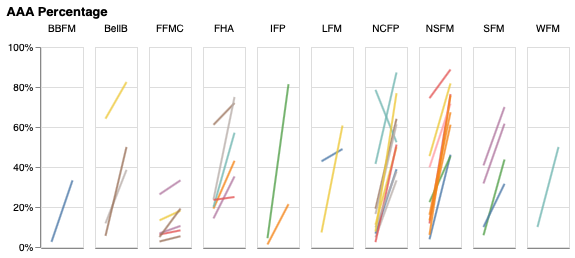

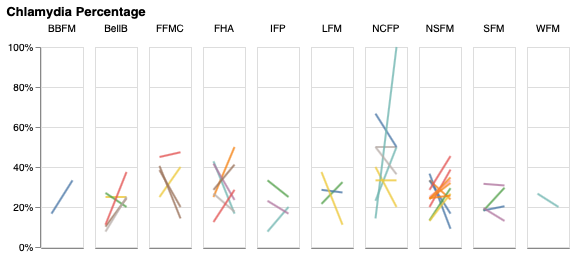

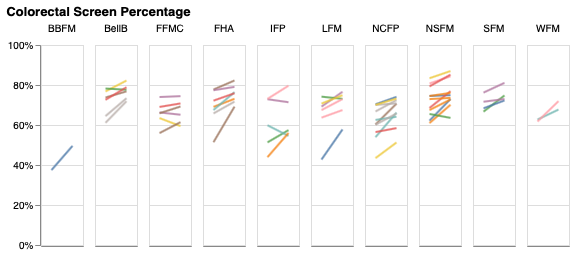

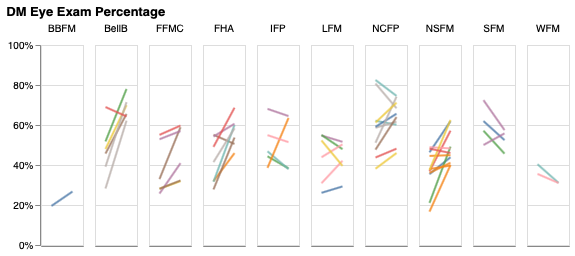

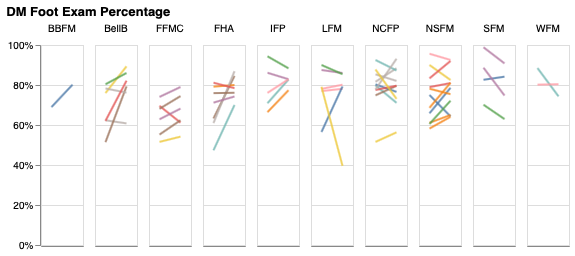

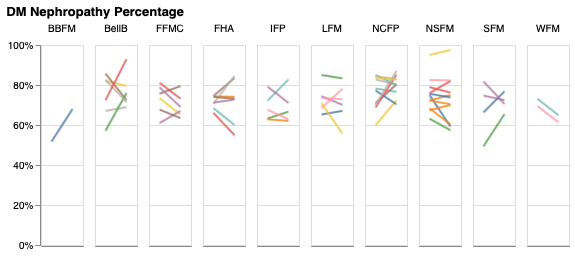

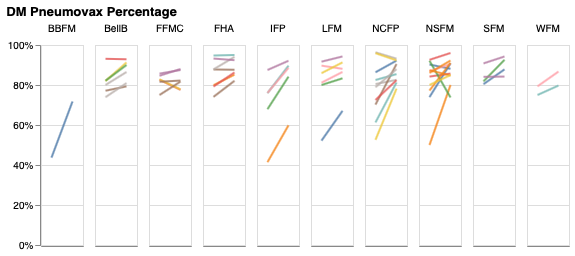

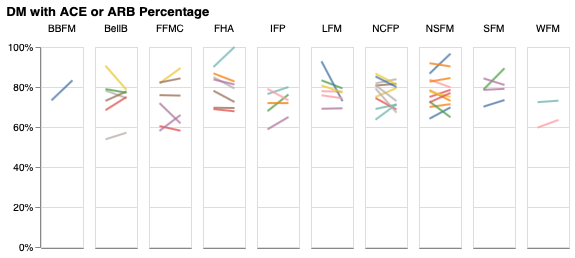

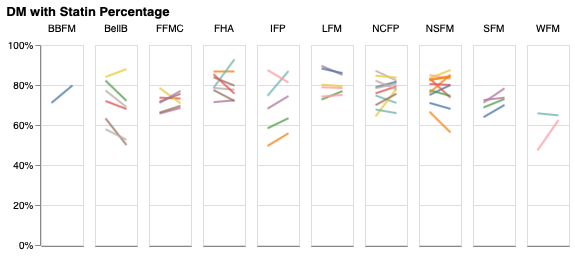

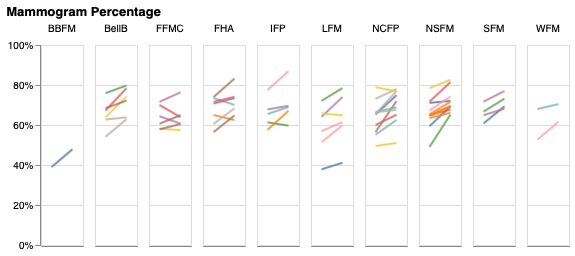

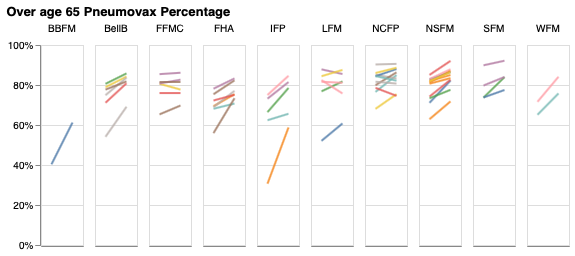

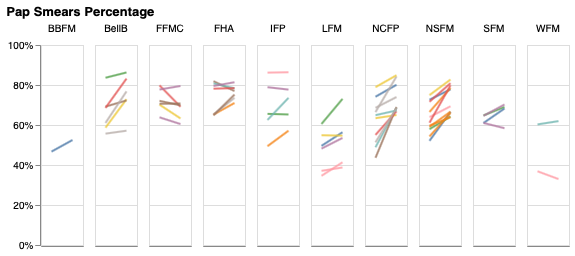

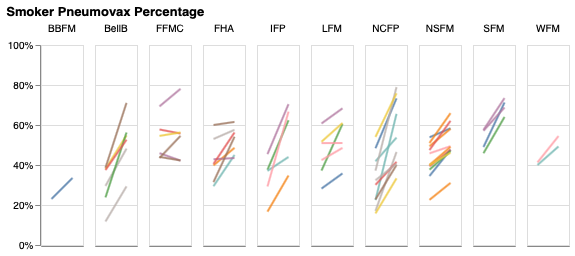

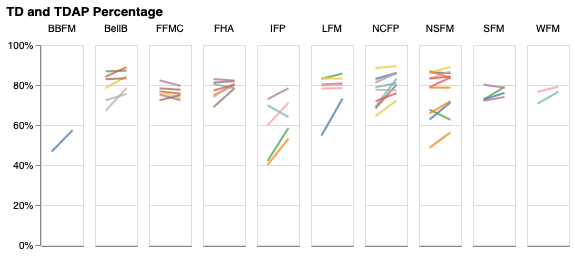

In [15]:
start_date = min(df["Date"])
current_date = max(df["Date"])

def metric_progress_overview(metric):
    individual_start = df[
            (df["Metric"] == metric)
            & (df["Date"] == start_date)
            & (df["Type"] == "Individual")]

    individual_current = df[
            (df["Metric"] == metric)
            & (df["Date"] == current_date)
            & (df["Type"] == "Individual")]

    individual_progress = pd.concat([individual_start, individual_current])
    
    chart = alt.Chart(individual_progress, height=200, title=str(metric)+" Percentage" ).mark_line().encode(
        x=alt.X('Date:O', axis=alt.Axis(title="", ticks=False, labels=False)),
        y=alt.Y('Percentage:Q', axis=alt.Axis(title="", format='%'), scale=alt.Scale(domain=(0,1))),
        color=alt.Color("Name", legend=None,),
        opacity=alt.value(0.8),
        column=alt.Column('Clinic', title=""),
        tooltip="Name",
    )
    return chart
    
for metric in main_metrics:
    chart = metric_progress_overview(metric)
    chart.display()
